<h1><span style="color:red">ChromID analysis</span></h1>



- paper: Villaseñor, Rodrigo, et al. "ChromID identifies the protein interactome at chromatin marks." Nature biotechnology 38.6 (2020): 728-736.

- GEO: [GSE128907](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE128907) 

# TOC

* [0. Data and task](#data)
* [1. Reads downsampling (later use)](#downsample)
* [2. Trimming](#trimming)
* [3. Alignment](#align)
* [4. Remove Duplicates](#duplicates)
* [5. Remove blacklist sequences](#blacklist)
* [6. Peak Calling](#peak_calling)
* [7. Genome Wide Coverage Plot](#vis_coverage)
* [8. Heatmaps peaks](#heatmaps_peaks)
* [9. Compare peaks - author vs reproduced](#compare)
* [10. Redo comparison after removing duplicates and blacklist](#redo)

In [40]:
%load_ext rpy2.ipython  

In [ ]:
%%R
library(dplyr)
library(stringr)
library(ggplot2)
library(viridis)
library(GenomicRanges)
library(ggpubr)
library(corrplot)
library(ggpubr)
library(magrittr) # to use %>%

In [ ]:
library(chromVAR) 
library(DESeq2)

In [68]:
import os
import sys
from helpers import hide_toggle # my scripts
from pybedtools import BedTool, cleanup
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn2_circles

# 0. Data and task <a class="anchor" id="data"> </a>

#### 0.b below data is donwloaded and fastq files are retrieved

| GEO | SRA | name | 
|---|---|:---|
|[GSM3688196](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688196)|SRR8788879|'MmES_bioGFP_r1',  
|[GSM3688197](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688197)|SRR8788880|'MmES_bioGFP_r2',    | 
|[GSM3688213](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688213)|SRR8788896|'MmES_**TAF3**_2xPhd_r1',
|[GSM3688214](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688213)|SRR8788897|'MmES_**TAF3**_2xPhd_r2',|
|[GSM3688201](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688201)|SRR8788884|'MmES_**MBD1**_MBD',     
|[GSM3688198](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688198)|SRR8788881|'MmES_**H3K27me3**',     
|[GSM3688199](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3688199)|SRR8788882|'MmES_**H3K4me3**',      

In [45]:
import pandas as pd

df = pd.read_csv("polybox/ChromID_raw_sequencing_files_list.csv", header=None, sep="\t")

for row in range(len(df)):
    row = df.iloc[row]
    row = row.to_string(index=False)
    row_list = row.strip().split(',')
    print(row_list)

['GSM3688213', 'MmES_TAF3_2xPhd_r1', 'SRR8788896']
['GSM3688214', 'MmES_TAF3_2xPhd_r2', 'SRR8788897']
['GSM3688196', 'MmES_bioGFP_r1', 'SRR8788879']
['GSM3688197', 'MmES_bioGFP_r2', 'SRR8788880']
['GSM3688198', 'MmES_H3K27me3', 'SRR8788881']
['GSM3688199', 'MmES_H3K4me3', 'SRR8788882']
['GSM3688201', 'MmES_MBD1_MBD', 'SRR8788884']


In [17]:
mapping = {
'SRR8788879':'bioGFP_r1',  
'SRR8788880':'bioGFP_r2',
'SRR8788896':'TAF3_2xPhd_r1',
'SRR8788897':'TAF3_2xPhd_r2',
'SRR8788884':'MBD1_MBD',     
'SRR8788881':'H3K27me3',     
'SRR8788882':'H3K4me3'
}

In [44]:
%%bash 
# download data
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data'
cd $data_folder
pwd
for sra in SRR8788896 SRR8788897 SRR8788879 SRR8788880 SRR8788881 SRR8788882 SRR8788884; do
    echo "downloading..."$sra;
    prefetch $sra
    echo "splitting paired reads..."
    fastq-dump --split-3 $sra --outdir $sra/
done

/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data
downloading...SRR8788896

splitting paired reads...
Rejected 50336912 READS because of filtering out non-biological READS
Read 50336912 spots for SRR8788896
Written 50336912 spots for SRR8788896
downloading...SRR8788897

splitting paired reads...
Rejected 46843195 READS because of filtering out non-biological READS
Read 46843195 spots for SRR8788897
Written 46843195 spots for SRR8788897
downloading...SRR8788879

splitting paired reads...
Read 58455988 spots for SRR8788879
Written 58455988 spots for SRR8788879
downloading...SRR8788880

splitting paired reads...
Read 37303595 spots for SRR8788880
Written 37303595 spots for SRR8788880
downloading...SRR8788881

splitting paired reads...
Rejected 51613505 READS because of filtering out non-biological READS
Read 51613505 spots for SRR8788881
Written 51613505 spots for SRR8788881
downloading...SRR8788882

splitting paired reads...
Rejected 44602665 READS because of filtering out n

2022-12-03T15:05:05 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-12-03T15:05:06 prefetch.3.0.1: 1) Downloading 'SRR8788896'...
2022-12-03T15:05:06 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2022-12-03T15:05:06 prefetch.3.0.1:  Downloading via HTTPS...
2022-12-03T15:06:06 prefetch.3.0.1:  HTTPS download succeed
2022-12-03T15:06:12 prefetch.3.0.1:  'SRR8788896' is valid
2022-12-03T15:06:12 prefetch.3.0.1: 1) 'SRR8788896' was downloaded successfully
2022-12-03T15:06:12 prefetch.3.0.1: 'SRR8788896' has 0 unresolved dependencies
2022-12-03T15:10:24 prefetch.3.0.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2022-12-03T15:10:24 prefetch.3.0.1: 1) Downloading 'SRR8788897'...
2022-12-03T15:10:24 prefetch.3.0.1: SRA Normalized Format file is being retrieved, if this

In [46]:
%%bash
data_folder='/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data'
cd $data_folder
pwd
for sra in SRR8788896 SRR8788897 SRR8788879 SRR8788880 SRR8788881 SRR8788882 SRR8788884; do
    mv $sra".fastq" $sra/
done

/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data


In [14]:
root="/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

In [ ]:
# rename reads files
import os

for (dirpath, dirnames, filenames) in os.walk(os.path.join(root,'data/reads')):
    for file in filenames:
        if file.endswith(".fastq"):
            sra, _ = file.strip().split('.')
            id_sample = mapping[sra]
            
            new_filename = f"{dirpath}/{id_sample}.fastq"
            cmd = f"mv {dirpath}/{file} {new_filename}"
            print(cmd)
            os.system(cmd)

In [4]:
!pwd
!mkdir -p data/reads
!mv data/SRR* data/reads

/network/projects/grn_control/bow/NanoTag/nanotag


#### 0.c Quality Control

In [ ]:
!mkdir -p raw-fastqc

import os

for (dirpath, dirnames, filenames) in os.walk(os.path.join(root,'data/reads')):
    for file in filenames:
        if file.endswith(".fastq"):
            filepath = os.path.join(dirpath, file)
            cmd = f"fastqc -o {root}/raw-fastqc --threads 32 {filepath}"
            os.system(cmd)
            
            
# or in bash
!for file in data/reads/*/*.fastq; do echo $file && fastqc -o raw-fastqc/ --threads 32 $file ; done

In [18]:
!cd raw-fastqc/ && multiqc .


  /// ]8;id=669245;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.13

|           multiqc | Search path : /network/projects/grn_control/bow/NanoTag/nanotag/raw-fastqc
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 14/14  stqc.htmlF3_2xPhd_r1_fastqc.html
|            fastqc | Found 7 reports
|           multiqc | Compressing plot data
|           multiqc | Report      : multiqc_report.html
|           multiqc | Data        : multiqc_data
|           multiqc | MultiQC complete


# 1. Reads downsampling (later use) <a class="anchor" id="downsample"> </a>

In [68]:
%%bash

# downsampled-reads=data/downsampled-reads
mkdir -p data/downsampled-reads
# mv data/data/reads/downsampled-reads data/

mkdir
for f in data/reads/*/*.fastq;
do
    echo "downsampling" $f
    save_to=${f##*/}
    
    # echo "tot reads before:"
    # grep '@' $f | wc -l
    
    /home/mila/i/ionelia.buzatu/bow/programs/seqtk/seqtk sample -s100 $f 7000000 > data/downsampled-reads/$save_to
    
done   

downsampling data/reads/SRR8788879/bioGFP_r1.fastq
downsampling data/reads/SRR8788880/bioGFP_r2.fastq
downsampling data/reads/SRR8788881/H3K27me3.fastq
downsampling data/reads/SRR8788882/H3K4me3.fastq
downsampling data/reads/SRR8788884/MBD1_MBD.fastq
downsampling data/reads/SRR8788896/TAF3_2xPhd_r1.fastq
downsampling data/reads/SRR8788897/TAF3_2xPhd_r2.fastq


mkdir: missing operand
Try 'mkdir --help' for more information.


# 2. Trimming <a class="anchor" id="trimming"> </a>

In [ ]:
!mkdir -p trim-galore
!for i in data/reads/*/*.fastq; \
    do /home/mila/i/ionelia.buzatu/bow/programs/TrimGalore-0.6.6/trim_galore -o trim-galore --cores 32 $i; done

### Reads stats after trimming

In [28]:
cmd="grep '@' {} | wc -l"
root="/network/projects/grn_control/bow/NanoTag/nanotag"
df_tot_reads = []
import sys
import os
for (dirpath, dirnames, filenames) in os.walk(os.path.join(root,'data/reads')):
    
    if not filenames:
        continue
        
    sra, fastq = filenames
    sample = fastq.split('.')[0]
    
    raw_filepath = f"{dirpath}/{fastq}"
    trimmed_filepath = os.path.join(root, f"trim-galore/{sample}_trimmed.fq")
    
    assert os.path.exists(raw_filepath), print(raw_filepath)
    assert os.path.exists(trimmed_filepath), print("erorr filepath:", trimmed_filepath)
    
    tot_reads_original = os.popen(cmd.format(raw_filepath)).read().strip()
    tot_reads_trimmed = os.popen(cmd.format(trimmed_filepath)).read().strip()
    
    df_tot_reads.append([sample, tot_reads_original, tot_reads_trimmed])

In [34]:
import pandas as pd
df = pd.DataFrame(df_tot_reads)

df[1] = df[1].astype('int64')
df[2] = df[2].astype('int64')

df.columns = ["sample", "n_raw_reads", "n_trimmed_reads"]

df['sample'] = df['sample'].astype('category')

In [48]:
df

,sample,n_raw_reads,n_trimmed_reads
0,bioGFP_r1,81768534,80567815
1,bioGFP_r2,56719611,54438405
2,H3K27me3,51613505,51612004
3,H3K4me3,44602665,44599675
4,MBD1_MBD,61961055,60837867
5,TAF3_2xPhd_r1,50336912,50305015
6,TAF3_2xPhd_r2,46843195,46839861


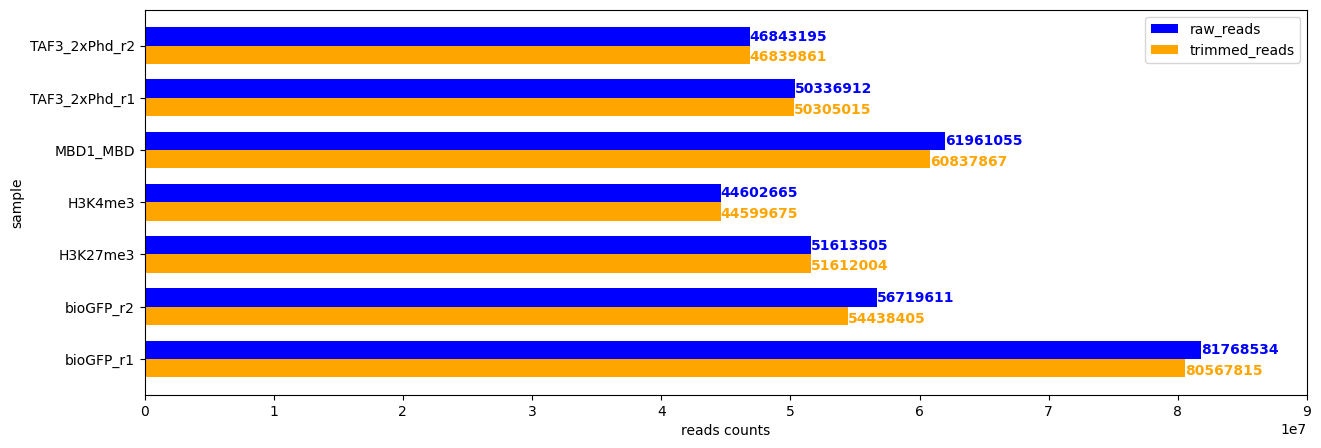

In [144]:
import numpy as np

fig, ax = plt.subplots(figsize=(15,5))

x = np.arange(7)
width = 0.35 

ax.barh(x + width/2, df['n_raw_reads'], width, label="raw_reads", color="blue") 

ax.barh(x - width/2, df['n_trimmed_reads'], width, label="trimmed_reads", color="orange") 

plt.yticks(x, df['sample']) #, rotation=35);

for i, v in enumerate(df['n_raw_reads']):
    ax.text(v + 4, i + .1, str(v), color='blue', fontweight='bold')
    
for i, v in enumerate(df['n_trimmed_reads']):
    ax.text(v + 3, i - .3, str(v), color='orange', fontweight='bold')

ax.legend()
ax.set_xlim(0, 90_000_000)

ax.set_xlabel("reads counts")
ax.set_ylabel("sample")
plt.show()

# 3. Alignment <a class="anchor" id="align"> </a>

In [ ]:
%%bash

mkdir -p ./data/aligned/sam
mkdir -p ./data/aligned/bam
mkdir -p ./data/aligned/bed
mkdir -p ./data/aligned/bedgraph
mkdir -p ./data/aligned/bigwig-coverage
mkdir -p ./data/aligned/logs

mm10_index_file='/network/projects/_groups/grn_control/bow/bowtie2/mm10/mm10'
root="/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

for i in SRR8788879,bioGFP_r1 SRR8788880,bioGFP_r2 SRR8788896,TAF3_2xPhd_r1 SRR8788897,TAF3_2xPhd_r2 SRR8788884,MBD1_MBD SRR8788881,H3K27me3 SRR8788882,H3K4me3; do
    IFS=","; set -- $i; 
    sra=$1
    id_name=$2
    echo doing: ${id_name}
    
    # alignment files
    trimmed_fastq_file=${root}/trim-galore/${id_name}_trimmed.fq
    output_sam_file=${root}/data/aligned/sam/${id_name}_bowtie2.sam
    stdout_file=${root}/data/aligned/logs/${id_name}_bowtie2.txt
    
    # convert and sort files 
    mapped_bam=${root}/data/aligned/bam/${id_name}.bowtie2.mapped.bam
    sorted_bam_output=${root}/data/aligned/bam/${id_name}.bowtie2.sorted.bam
    
    echo ${id_name}': alignment to reference'
    bowtie2 -p 32 -x $mm10_index_file -U $trimmed_fastq_file -S $output_sam_file -m 1 --best --strata > $stdout_file
    
    echo "sort and index bam"    
    cat $output_sam_file | samtools view -bS | samtools sort -@8 -m 8G > $sorted_bam_output
    samtools index $sorted_bam_output

    
done    

### Sequencing depth stats table

In [ ]:
%%R

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/nanotag"
samples_list_path = c('bioGFP_r1', 'bioGFP_r2', 'TAF3_2xPhd_r1', 'TAF3_2xPhd_r2', 'MBD1_MBD')
samples_list_for_rep = c('bioGFP_r1', 'bioGFP_r2', 'TAF3_r1', 'TAF3_r2', 'MBD1_r1')
tuple_samples = mapply(c, samples_list_path, samples_list_for_rep, SIMPLIFY = FALSE)

## Collect the alignment results from the bowtie2 alignment summary files
alignResult = c()

for(pair in tuple_samples){
    hist = pair[1]
    rep = pair[2]
    path_txt = paste0(projPath, "/data/aligned/logs/", hist, "_bowtie2.txt") 
    alignRes = read.table(path_txt, header = FALSE, fill = TRUE)
    alignRate = substr(alignRes$V1[6], 1, nchar(as.character(alignRes$V1[6]))-1)
    histInfo = strsplit(rep, "_")[[1]]
    alignResult = data.frame(Residue = histInfo[1], Replicate = histInfo[2], 
                             SeqDepth = alignRes$V1[1] %>% as.character %>% as.numeric, 
                             MappedFragNum_mm10 = alignRes$V1[4] %>% as.character %>% as.numeric + alignRes$V1[5] 
                             %>% as.character %>% as.numeric, 
                             AlignRatEmm10 = alignRate %>% as.numeric)  %>% rbind(alignResult, .)
}

alignResult$Histone = factor(alignResult$Residue, levels = samples_list)
alignResult = alignResult %>% mutate(AlignRatEmm10 = paste0(AlignRatEmm10, "%"))
write.csv(alignResult,"csvs/alignResult.csv", row.names = FALSE)

In [180]:
%%R
alignResult = read.csv("csvs/alignResult.csv")
alignResult

   Residue Replicate SeqDepth MappedFragNum_mm10 AlignRatEmm10
1   bioGFP        r1 57904904           56859606        98.19%
2   bioGFP        r2 36137591           35427017        98.03%
3     TAF3        r1 50305015           49586494        98.57%
4     TAF3        r2 46839861           46297475        98.84%
5     MBD1        r1 40080359           39256476        97.94%
6 H3K27me3        r1 51612004           50944193        98.71%
7  H3K4me3        r1 44599675           43963083        98.57%


### Visualize alignment stats

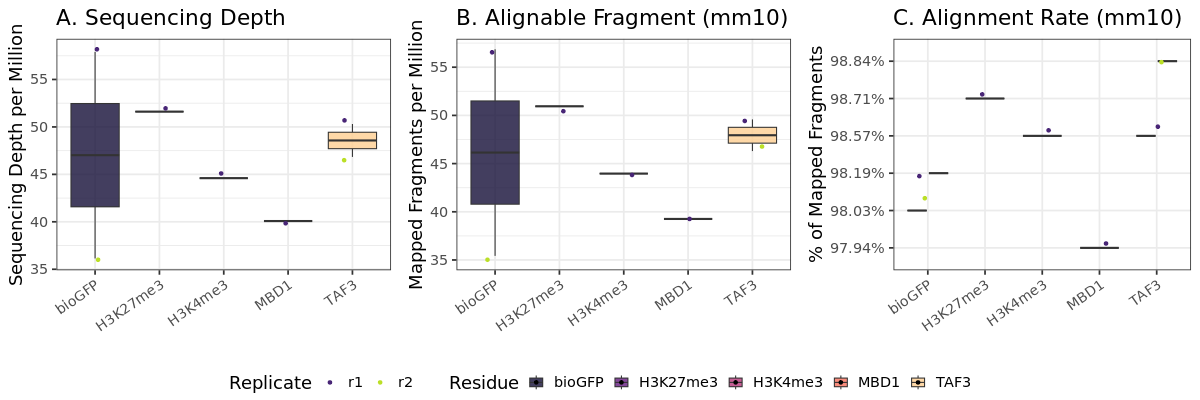

In [188]:
%%R -w 1200 -h 400

## Generate sequencing depth boxplot
fig3A = alignResult %>% ggplot(aes(x = Residue, y = SeqDepth/1000000, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Sequencing Depth per Million") +
    xlab("") + 
    ggtitle("A. Sequencing Depth") +
    scale_x_discrete(guide = guide_axis(angle = 35)) 

fig3B = alignResult %>% ggplot(aes(x = Residue, y = MappedFragNum_mm10/1000000, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("Mapped Fragments per Million") +
    xlab("") +
    ggtitle("B. Alignable Fragment (mm10)") + scale_x_discrete(guide = guide_axis(angle = 35))

fig3C = alignResult %>% ggplot(aes(x = Residue, y = AlignRatEmm10, fill = Residue)) +
    geom_boxplot() +
    geom_jitter(aes(color = Replicate), position = position_jitter(0.15)) +
    scale_fill_viridis(discrete = TRUE, begin = 0.1, end = 0.9, option = "magma", alpha = 0.8) +
    scale_color_viridis(discrete = TRUE, begin = 0.1, end = 0.9) +
    theme_bw(base_size = 18) +
    ylab("% of Mapped Fragments") +
    xlab("") +
    ggtitle("C. Alignment Rate (mm10)") + scale_x_discrete(guide = guide_axis(angle = 35))
    


ggarrange(fig3A, fig3B, fig3C, ncol = 3, common.legend = TRUE, legend="bottom")    

In [78]:
!mkdir -p data/aligned/bam/sorted
!mv data/aligned/bam/*bowtie2* data/aligned/bam/sorted/

In [91]:
!mkdir -p data/aligned/bam/indexed/marking_metrics

# 4. Remove duplicates <a class="anchor" id="duplicates"> </a>

In [ ]:
%%bash

for f in data/aligned/bam/sorted/*.bam;
do
    name=${f##*/}

    echo --- $f
    bam_without_duplicates_output="data/removed-duplicates/$name.rmDup.bam"
    removed_dup_metrics_file="data/removed-duplicates/logs/$name.picard.rmDup.txt"
           
    sam_sorted_output="data/removed-duplicates/sorted-sortsam/${name}.sorted.sam"
           
    echo "-------------------- sorting by coordinate -------------------"
    java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar SortSam -I $f -O $sam_sorted_output -SORT_ORDER coordinate      
    
    echo "--------------------- remove duplicates ----------------------"       
    java -XX:ParallelGCThreads=8 -jar /home/mila/i/ionelia.buzatu/comp-venv/bin/picard.jar MarkDuplicates \
        -I $f -O $bam_without_duplicates_output --REMOVE_DUPLICATES true -METRICS_FILE $removed_dup_metrics_file
    
done

In [327]:
%%R -w 900 -h 10000

projPath = "/network/projects/_groups/grn_control/bow/NanoTag/nanotag"
samples_list_for_rep = c('bioGFP_r1', 'bioGFP_r2', 'TAF3_2xPhd_r1', 'TAF3_2xPhd_r2', 'MBD1_MBD')
histList =c('bioGFP', 'TAF3', 'MBD1')
alignResult = c()
dupResult = NULL


for(sample in samples_list_for_rep){
  
    dupRes = read.table(paste0(projPath, "/data/removed-duplicates/logs/", sample, ".rmDup.txt"), header = TRUE, fill = TRUE)
    histInfo = strsplit(sample, "_")[[1]]  
    sample=histInfo[1]
    replicate=tail(histInfo, n=1)
    dupResult = data.frame(Histone = sample, Replicate = replicate, MappedFragNum_mm10 = dupRes$READ_PAIRS_EXAMINED[1] 
                         %>% as.character %>% as.numeric, DuplicationRate = dupRes$PERCENT_DUPLICATION[1] 
                         %>% as.character %>% as.numeric * 100, EstimatedLibrarySize = dupRes$ESTIMATED_LIBRARY_SIZE[1] 
                       %>% as.character %>% as.numeric) %>% mutate(UniqueFragNum = MappedFragNum_mm10 * (1-DuplicationRate/100)) %>% rbind(dupResult, .)
}

dupResult$Histone = factor(dupResult$Histone, levels = histList)
# write.csv(dupResult, "dupications_results.csv", row.names = FALSE)
dupResult

  Histone Replicate MappedFragNum_mm10 DuplicationRate EstimatedLibrarySize
1  bioGFP        r1           56859606               0             0.108655
2  bioGFP        r2           35427017               0             0.125302
3    TAF3        r1           49586494               0             0.231874
4    TAF3        r2           46297475               0             0.235709
5    MBD1       MBD           39256476               0             0.140877
  UniqueFragNum
1      56859606
2      35427017
3      49586494
4      46297475
5      39256476


#### Inspecting the logs files output from `MarkDuplicates --REMOVE_DUPLICATES true`

In [331]:
%%bash

for f in data/removed-duplicates/logs/*txt;do
    cat $f
    echo ------------------------------
    done

## htsjdk.samtools.metrics.StringHeader
# MarkDuplicates --INPUT bioGFP_r1.bowtie2.sorted.bam --OUTPUT bioGFP_r1.bowtie2.rmDup.bam --METRICS_FILE bioGFP_r1.picard.rmDup.txt --REMOVE_DUPLICATES true --MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP 50000 --MAX_FILE_HANDLES_FOR_READ_ENDS_MAP 8000 --SORTING_COLLECTION_SIZE_RATIO 0.25 --TAG_DUPLICATE_SET_MEMBERS false --REMOVE_SEQUENCING_DUPLICATES false --TAGGING_POLICY DontTag --CLEAR_DT true --DUPLEX_UMI false --FLOW_MODE false --FLOW_QUALITY_SUM_STRATEGY false --USE_END_IN_UNPAIRED_READS false --USE_UNPAIRED_CLIPPED_END false --UNPAIRED_END_UNCERTAINTY 0 --FLOW_SKIP_FIRST_N_FLOWS 0 --FLOW_Q_IS_KNOWN_END false --FLOW_EFFECTIVE_QUALITY_THRESHOLD 15 --ADD_PG_TAG_TO_READS true --ASSUME_SORTED false --DUPLICATE_SCORING_STRATEGY SUM_OF_BASE_QUALITIES --PROGRAM_RECORD_ID MarkDuplicates --PROGRAM_GROUP_NAME MarkDuplicates --READ_NAME_REGEX <optimized capture of last three ':' separated fields as numeric values> --OPTICAL_DUPLICATE_PIXEL_DISTANCE 100 --MA

# 5. Remove blacklist sequences <a class="anchor" id="blacklist"> </a>

In [ ]:
%%bash

bed_file="data/polybox/blacklist_mm10_v2.bed"

for f in data/removed-duplicates/*bam;

do

    tmp=${f##*/}
    name=${tmp%.bam}
    echo name: $name
    
    echo "filtered $name"
    bedtools intersect -v -a $f -b $bed_file | samtools view -h -b --threads 32 -q 30 -F 0x4 \
          | samtools view -h --threads 32 | egrep -v chrM | samtools view -b -h --threads 32 > data/aligned/bam/indexed/$name-ind.bam
    
    
    echo "indexed $name"
    echo samtools index -b data/aligned/bam/indexed/$name-ind.bam

          
done

In [266]:
# check file size before and after removing blacklist.bed
!ls data/aligned/bam/indexed/bioGFP_r1.bowtie2.rmDup-ind.bam -lh
!ls data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam -lh

-rw-r--r-- 1 ionelia.buzatu ionelia.buzatu 2.5G Dec 13 10:47 data/aligned/bam/indexed/bioGFP_r1.bowtie2.rmDup-ind.bam
-rw-r--r-- 1 ionelia.buzatu ionelia.buzatu 3.3G Dec  8 09:30 data/aligned/bam/sorted/bioGFP_r1.bowtie2.sorted.bam


# 5. Merge replicates <a class="anchor" id="merge_replicates"> </a>

In [333]:
%%bash

root_merged=data/aligned/bam/merged/after-indexed
root_indexed=data/aligned/bam/indexed/

mkdir -p $root_merged

# merge bioGFP replicates
samtools merge -o $root_merged/bioGFP_merged.bam $root_indexed/bioGFP_r1.bowtie2.rmDup-ind.bam $root_indexed/bioGFP_r2.bowtie2.rmDup-ind.bam
samtools index -b $root_merged/bioGFP_merged.bam

# merge TAF3 replicates
samtools merge -o $root_merged/TAF3_2xPhd_merged.bam $root_indexed/TAF3_2xPhd_r1.bowtie2.sorted.rmDup-ind.bam $root_indexed/TAF3_2xPhd_r2.bowtie2.sorted.rmDup-ind.bam
samtools index -b $root_merged/TAF3_2xPhd_merged.bam

# 6. Peak calling <a class="anchor" id="peak_calling"> </a>

In [ ]:
%%bash

mkdir -p peaks/final

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final -n ctr \
    --gsize mm -t data/aligned/bam/merged/after-indexed/bioGFP_merged.bam --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \ 
    -t data/aligned/bam/indexed/MBD1_MBD.bowtie2.sorted.rmDup-ind.bam
    -n MBD1 --gsize mm --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -t data/aligned/bam/merged/TAF3_2xPhd_merged.bam \
    -n TAF3_2xPhd_merged --gsize mm --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -t data/aligned/bam/indexed/TAF3_2xPhd_r1.bowtie2.sorted.rmDup-ind.bam \
    -n TAF3_2xPhd_r1 --gsize mm --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -t data/aligned/bam/indexed/TAF3_2xPhd_r2.bowtie2.sorted.rmDup-ind.bam \
    -n TAF3_2xPhd_r2 --gsize mm --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -t data/aligned/bam/indexed/H3K27me3.bowtie2.sorted.rmDup-ind.bam \
    -n H3K27me3 --gsize mm --broad-cutoff 0.1 

macs2 callpeak --nomodel --broad --nolambda --outdir peaks/final \
    -c data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -t data/aligned/bam/indexed/H3K4me3.bowtie2.sorted.rmDup-ind.bam \
    -n H3K4me3 --gsize mm --broad-cutoff 0.1 

### Convert the generated boardPeaks to bed format

In [4]:
%%bash
move_to=peaks/final/broadpeaks-to-bed
mkdir -p $move_to

for f in peaks/final/*peaks.broadPeak;
do
    bed_filepath=${move_to}/${f##*/}.bed
    echo $bed_filepath
    sed '1d' $f | cut -f 1-3 > $bed_filepath
done

peaks/final/broadpeaks-to-bed/ctr_peaks.broadPeak.bed
peaks/final/broadpeaks-to-bed/H3K27me3_peaks.broadPeak.bed
peaks/final/broadpeaks-to-bed/H3K4me3_peaks.broadPeak.bed
peaks/final/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed
peaks/final/broadpeaks-to-bed/TAF3_peaks.broadPeak.bed


#### merge peak bed file for TAF3 (used to compare it with the author's)

In [34]:
!samtools merge -o peaks/broadpeaks-to-bed/TAF3_2xPhd_merged.bed \
    peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed

In [35]:
!cat peaks/broadpeaks-to-bed/TAF3_2xPhd_r* | sort -k1,1 -k2,2n | bedtools merge -i - > taf3_merged.bed

# 7. Genome Wide Coverage Plot <a class="anchor" id="vis_coverage"> </a>

In [345]:
%%bash
bedtools bamtobed -i data/aligned/bam/indexed/H3K4me3.bowtie2.sorted.rmDup-ind.bam -bedpe >data/aligned/bed/H3K4me3.bowtie2.sorted.rmDup.bed

In [338]:
%%bash

mkdir -p bigwigs/final

bamCoverage -b data/aligned/bam/indexed/H3K27me3.bowtie2.sorted.rmDup-ind.bam -o bigwigs/final/H3K27me3.bw \
           --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

bamCoverage -b data/aligned/bam/indexed/H3K4me3.bowtie2.sorted.rmDup-ind.bam -o bigwigs/final/H3K4me3.bw \
           --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

bamCoverage -b data/aligned/bam/indexed/MBD1_MBD.bowtie2.sorted.rmDup-ind.bam \
    -o bigwigs/final/MBD1_MBD.bw --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

bamCoverage -b data/aligned/bam/merged/after-indexed/TAF3_2xPhd_merged.bam \
    -o bigwigs/final/TAF3_merged.bw --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

bamCoverage -b data/aligned/bam/merged/after-indexed/bioGFP_merged.bam \
    -o bigwigs/final/bioGFP_merged.bw --normalizeUsing RPGC --effectiveGenomeSize 2730871774 --numberOfProcessors 32

## Fig. 1d

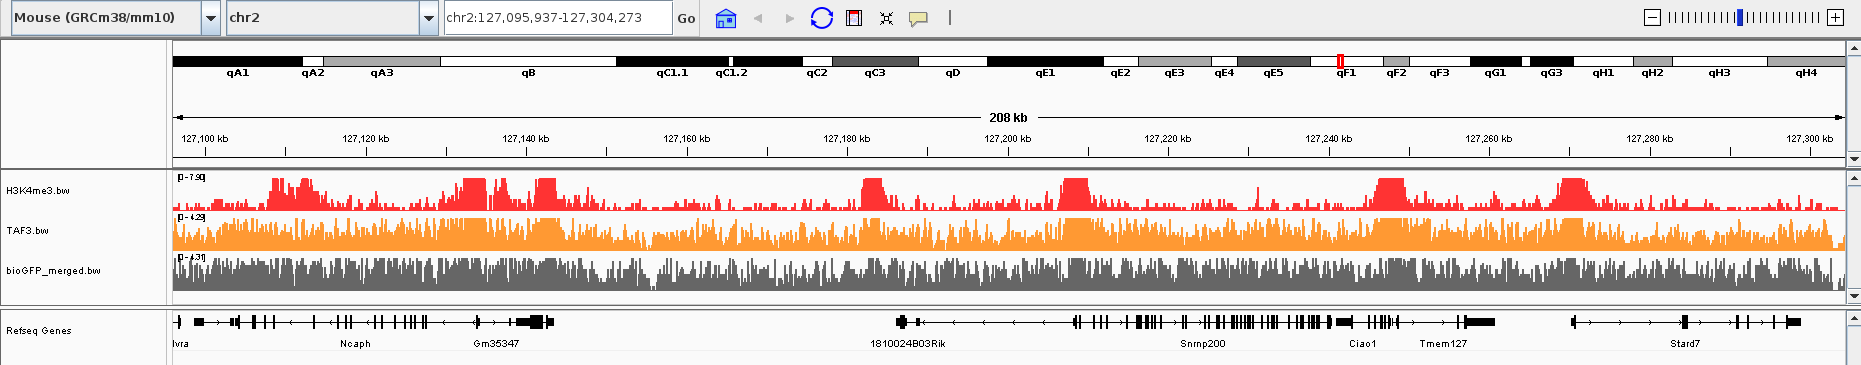

## Fig. 1f

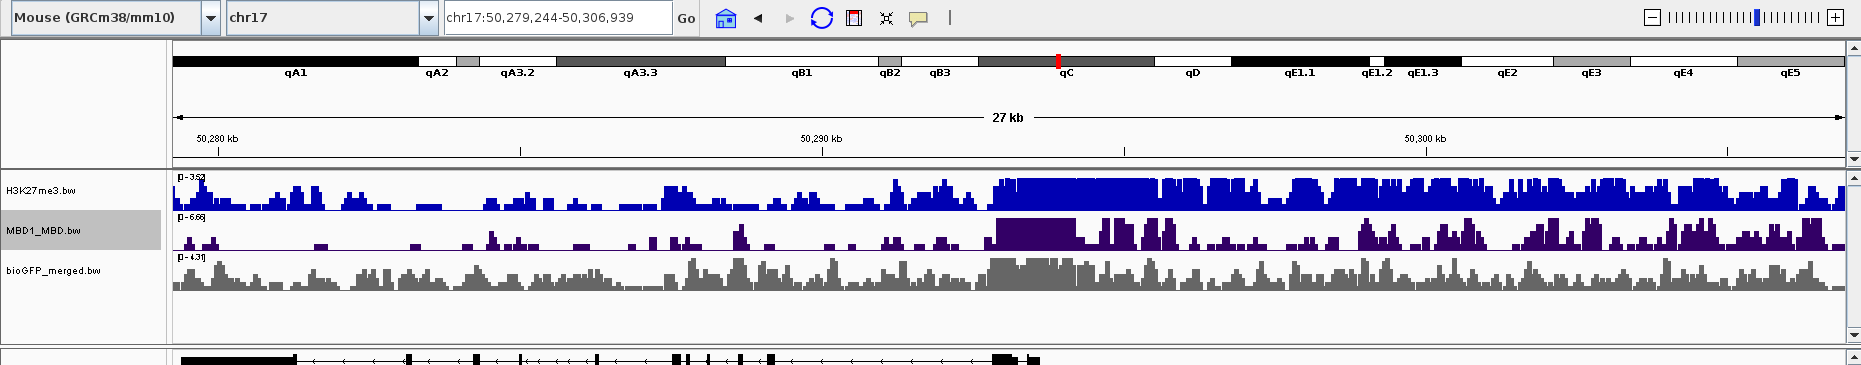

# 8. Heapmap Chip-seq peaks <a class="anchor" id="heatmaps_peaks"> </a>

In [128]:
%%bash


mkdir -p matrix-genes/final
mkdir -p heatmaps/peaks/final/
bigwigs_root=bigwigs/final/blacklist
author_beds_root=/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data/polybox/mm10/

# plot peaks author using bigwig generated above
computeMatrix reference-point -S bigwigs/final/blacklist/MBD1_MBD.bw -R $author_beds_root/MBD1_MBD_combined_peaks_mm10_output.bed 
    --referencePoint center -a 2000 -b 2000 --binSize 5 --skipZeros \
    -out matrix-genes/final/bigwigs-with-blacklist/author_MBD1_MBD_combined_peaks_mm10_after_blacklist.tab.gz -p 32 --missingDataAsZero 

plotHeatmap -m matrix-genes/final/bigwigs-with-blacklist/author_MBD1_MBD_combined_peaks_mm10_after_blacklist.tab.gz \
    -out heatmaps/peaks/final/author_MBD1_MBD_combined_peaks_mm10.png --heatmapHeight 15 
    --refPointLabel peak.center --regionsLabel peaks --plotTitle 'author_MBD1_MBD' 


computeMatrix reference-point \
    -S $bigwigs_root/TAF3_merged.bw -R $author_beds_root/TAF3-2xPHD_combined_peak_mm10_output.bed --referencePoint center -a 2000 -b 2000 \ 
    --binSize 5 -p 32 --missingDataAsZero -out matrix-genes/final/bigwigs-with-blacklist/author_TAF3_merged_mm10.tab.gz 

plotHeatmap -m matrix-genes/final/bigwigs-with-blacklist/author_TAF3_merged_mm10.tab.gz -out heatmaps/peaks/final/author_TAF3_mm10.png \
    --heatmapHeight 15  --refPointLabel peak.center --regionsLabel peaks --plotTitle 'author_TAF3' 


# reproduced peaks
for f in bigwigs/final/blacklist/*.bw; do
    
    sample=${f##*/}
    name="${sample%.*}"

    computeMatrix reference-point \
    -S $f \
    -R peaks/final/broadpeaks-to-bed/${name}_peaks.broadPeak.bed \
    --referencePoint center -a 2000 -b 2000 --binSize 5 -p 32 --missingDataAsZero \
    -out matrix-genes/final/bigwigs-with-blacklist/${name}.tab.gz 
             
    plotHeatmap -m matrix-genes/final/bigwigs-with-blacklist/${name}.tab.gz  \
        -out heatmaps/peaks/final/bigwigs-with-blacklist/${sample}.png \
        --heatmapHeight 15 --refPointLabel peak.center --regionsLabel peaks \
        --plotTitle $sample         

done

In [ ]:
%%bash

# note for blacklist in this cell is meant bamCoverage without giving it the ctr file - i did with ctr separatly but there was no difference
mkdir -p matrix-genes/final/bigwigs-without-blacklist
root=/network/projects/_groups/grn_control/bow/NanoTag/nanotag

for f in bigwigs/final/without-blacklist/*.bw; do
    
    sample=${f##*/}
    name="${sample%.*}"

    computeMatrix reference-point \
        -S $f \
        -R peaks/final/broadpeaks-to-bed/${name}_peaks.broadPeak.bed \
        --referencePoint center -a 2000 -b 2000 --binSize 5 -p 32 --missingDataAsZero \
        -out matrix-genes/final/bigwigs-without-blacklist/${name}.tab.gz 
             
    plotHeatmap -m matrix-genes/final/bigwigs-without-blacklist/${name}.tab.gz  \
        -out $root/heatmaps/peaks/final/bigwigs-without-blackListFileName/${sample}.png \
        --heatmapHeight 15 --refPointLabel peak.center --regionsLabel peaks 
       #  --plotTitle $sample this arg is not needed
             
done

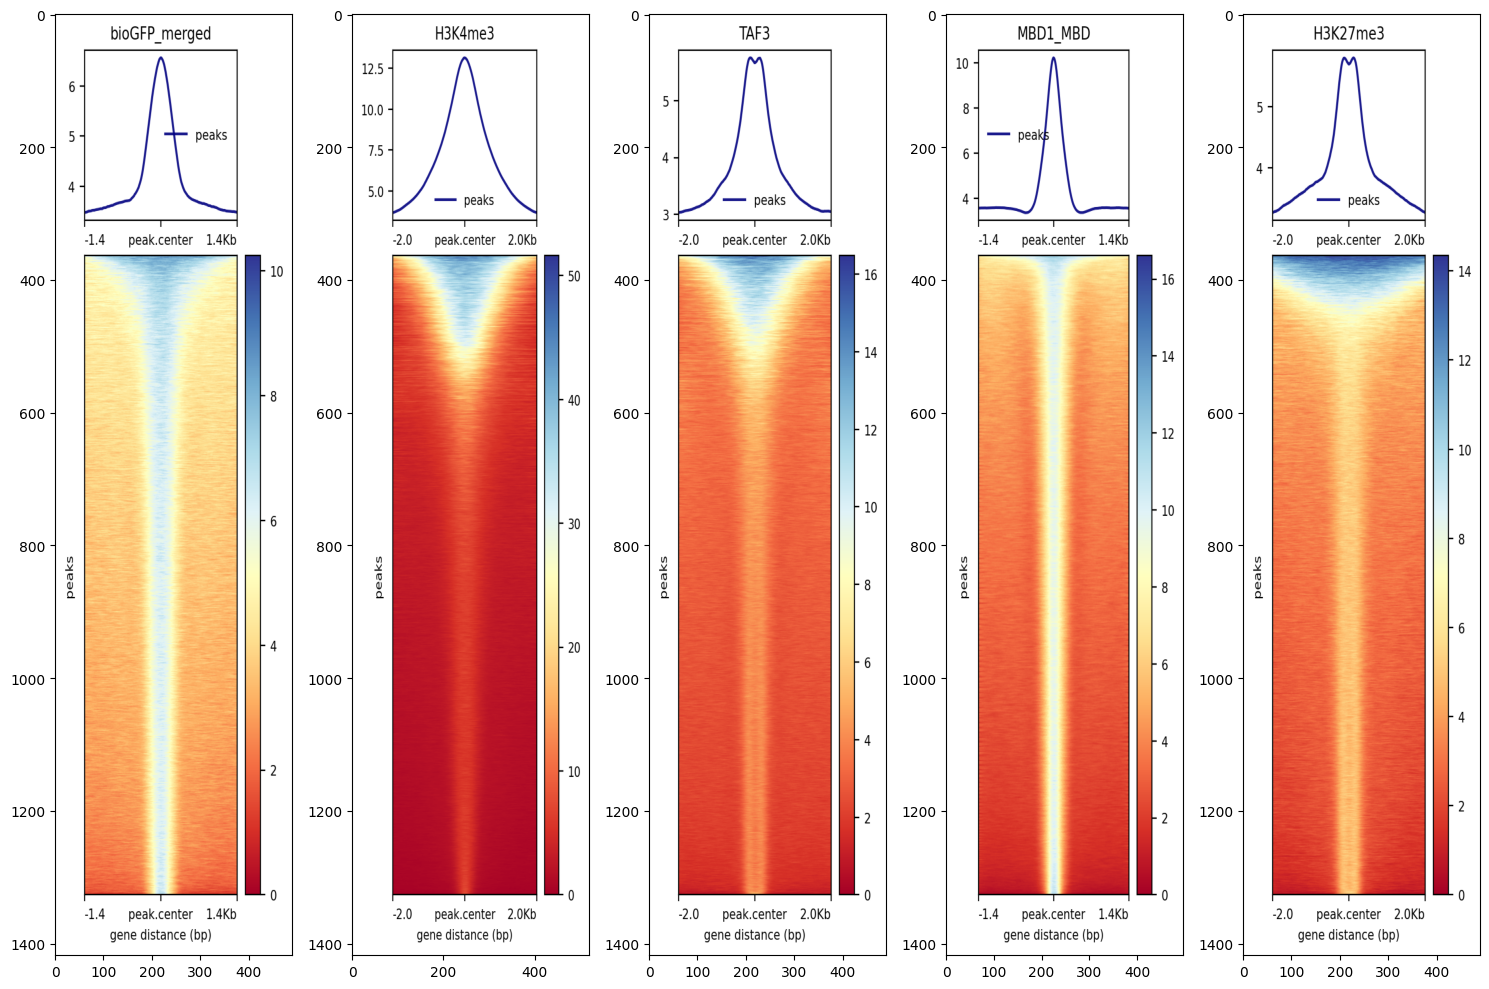

In [90]:
import os
import matplotlib.pyplot as plt

root_path="/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmaps/peaks/final"

plots_order={
    'MBD1_MBD': 3,
    'H3K27me3': 4,
    'H3K4me3': 1,
    'TAF3': 2,
    'bioGFP':0
}
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for idx, png_filepath in enumerate(os.listdir(root_path)):
    
    if not png_filepath.endswith("png"):
        continue
        
    basaname=png_filepath.split('.')[0]
    png_filepath = f"{root_path}/{png_filepath}"
    assert os.path.exists(png_filepath), print(png_filepath)
    
    img = plt.imread(png_filepath)
    ax[plots_order[basaname]].imshow(img, aspect="auto") 

fig.tight_layout()
fig.savefig("/network/projects/_groups/grn_control/bow/NanoTag/nanotag/heatmap_peaks.png") 
plt.show()

# 9. Compare author peaks with replicated peaks <a class="anchor" id="compare"> </a>

TODOs:

convert mm9 to mm10 author wig files
    
1. `wig2bed < GSM3688213_MmES_Taf3.2xPHD_r1.wig > GSM3688213_MmES_Taf3.2xPHD_r1.bed`    
2. `liftOver input.bed hg18To19.chain output.bed unlifted.bed`


liftOver=/home/mila/i/ionelia.buzatu/bow/programs/liftOver

`pip install intervene` can be used to venn diagram between two bed or multiple beds.

### Convert author mm9 peak files to mm10 assembly bed files

In [ ]:
# firt we need to convert the broadPeak to a bed format like below 
dir="~/bow/NanoTag/nanotag/data/polybox"
sed '1d'!sed '1d' $dir/broadpeak_MBD1_MBD_combined_peaks.broadPeak | cut -f 1-3 > $dir/MBD1_MBD_combined_peaks.bed
!sed '1d' $dir/broadpeak_TAF3-2xPHD_combined_peaks.broadPeak | cut -f 1-3 > $dir/TAF3-2xPHD_combined_peaks.bed

In [ ]:
# to mm10 assembly
liftover="/home/mila/i/ionelia.buzatu/bow/programs/liftOver"
mm9ToMm10_chain="/home/mila/i/ionelia.buzatu/bow/liftover-chains/mm9ToMm10.over.chain"

!$liftover $dir/MBD1_MBD_combined_peaks.bed $mm9ToMm10_chain \
    $dir/mm10/MBD1_MBD_combined_peaks_mm10_output.bed $dir/mm10/MBD1_MBD_combined_peaks_mm10_unlifted.bed

!$liftover $dir/TAF3-2xPHD_combined_peaks.bed \
    $mm9ToMm10_chain $dir/mm10/TAF3-2xPHD_combined_peak_mm10_output.bed $dir/mm10/TAF3-2xPHD_combined_peaks_mm10_unlifted.bed

In [36]:
%%bash

author_beds=/network/projects/_groups/grn_control/bow/NanoTag/nanotag/data/polybox/mm10

# note it will replace the output file fix it!
intervene venn -i $author_beds/MBD1_MBD_combined_peaks_mm10_output.bed peaks/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed
mv intervene_results/
intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed

intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed

intervene venn -i $author_beds/TAF3-2xPHD_combined_peak_mm10_output.bed taf3_merged.bed


Generating a 2-way "venn" diagram. Please wait...


Done! Please check your results @ /network/projects/grn_control/bow/NanoTag/nanotag/Intervene_results. 
Thank you for using Intervene!



#### MBD1 & TAF3:

- first trial (includes duplicates)

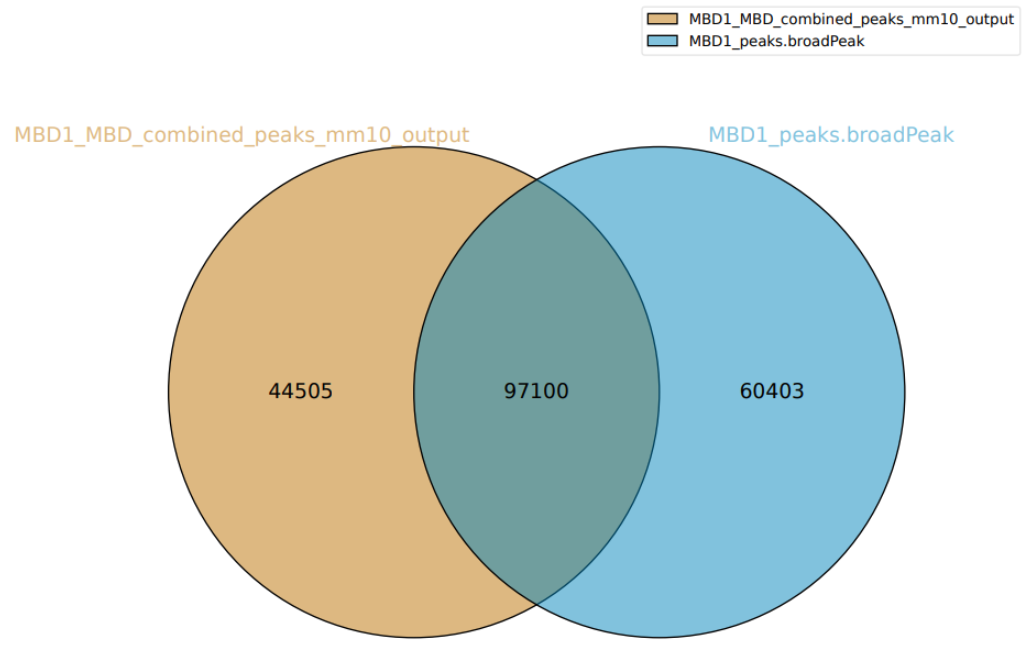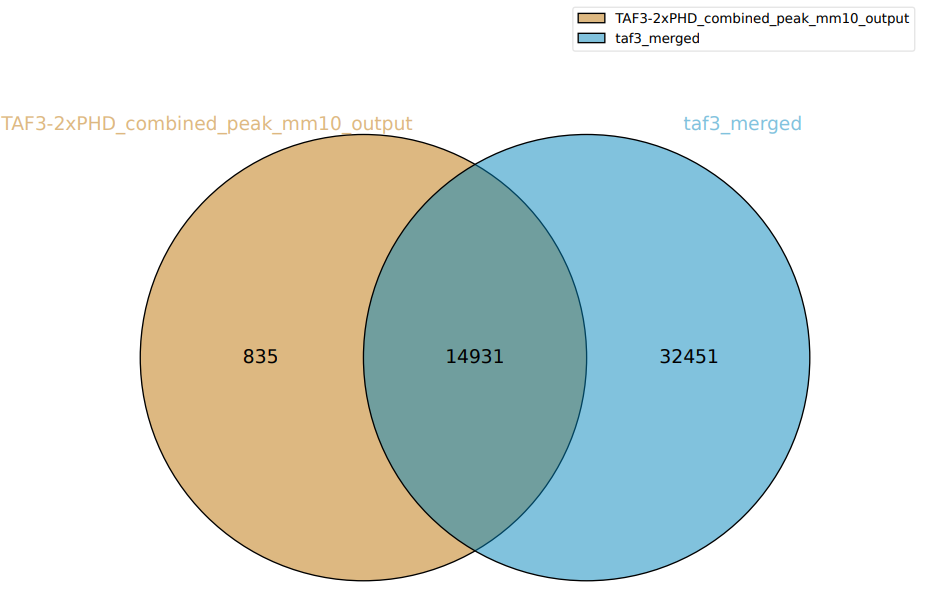

|peaks|similarity %|
|:--:|:--:|
|MBD1| 48%
|TAF3_merged|31%
|TAF3_r1|45%
|TAF3_r2|33%

# 10. Redo the comparison after removing duplicates and rmeoving blacklist sequences <a class="anchor" id="redo"> </a>

In addtion please note:

- They used bowtie1 instead here is bowtie2
- added '--broad-cutoff 0.1' after reading section 'Genomics data analysis' in the paper 

In [99]:
%%bash
# let's check the number of peaks from each file 
for f in peaks/broadpeaks-to-bed/*bed; do
    
    
    wc -l $f
    echo --------
done

# and the author peaks 
for f in data/polybox/mm10/*output*; do
    
    wc -l $f
    echo --------
done

34757 peaks/broadpeaks-to-bed/ctr_r1_peaks.broadPeak.bed
--------
159951 peaks/broadpeaks-to-bed/MBD1_peaks.broadPeak.bed
--------
28820 peaks/broadpeaks-to-bed/TAF3_2xPhd_r1_peaks.broadPeak.bed
--------
42795 peaks/broadpeaks-to-bed/TAF3_2xPhd_r2_peaks.broadPeak.bed
--------
141605 data/polybox/mm10/MBD1_MBD_combined_peaks_mm10_output.bed
--------
15766 data/polybox/mm10/TAF3-2xPHD_combined_peak_mm10_output.bed
--------


In [138]:
root="/network/projects/_groups/grn_control/bow/NanoTag/nanotag"

# load MBD1 beds file
a = BedTool(os.path.join(root,'data/polybox/mm10/MBD1_MBD_combined_peaks_mm10_output.bed'))
b = BedTool(os.path.join(root, 'peaks/final/broadpeaks-to-bed/MBD1_MBD_peaks.broadPeak.bed'))

# load TAF3 beds file
taf_author_bed = BedTool(os.path.join(root,'data/polybox/mm10/TAF3-2xPHD_combined_peak_mm10_output.bed'))
taf_reproduced_bed = BedTool(os.path.join(root, 'peaks/final/broadpeaks-to-bed/TAF3_peaks.broadPeak.bed'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))

# venn MBD1
n1  = (a-b).count() # unique to a
n2  = (b-a).count() # unique to b
n12 = (a+b).count() # common to all
total=sum([n1, n2, n12])
v1 = venn2(subsets=(n1, n2, n12), set_labels = ("author_MBD1_MBD", "reproduced_MBD1"),  ax=ax1, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
            
# venn TAF3
taf_set_1 = (taf_author_bed-taf_reproduced_bed).count() # unique to author_bed
taf_set_2  = (taf_reproduced_bed-taf_author_bed).count() # unique to reproduced TAF
taf_set_12 = (taf_author_bed+taf_reproduced_bed).count() # peaks in common (100% match)
total=sum([taf_set_1, taf_set_2, taf_set_12])
v2 = venn2(subsets=(taf_set_1, taf_set_2, taf_set_12),  ax=ax2, set_labels = ("author_TAF3", "reproduced_TAF3"),
          set_colors=('#00909e', '#f67280'), subset_label_formatter=lambda x: f"{(x/total):1.0%}" 
          )

fig.tight_layout()
plt.savefig("venns.pnd")

cleanup()

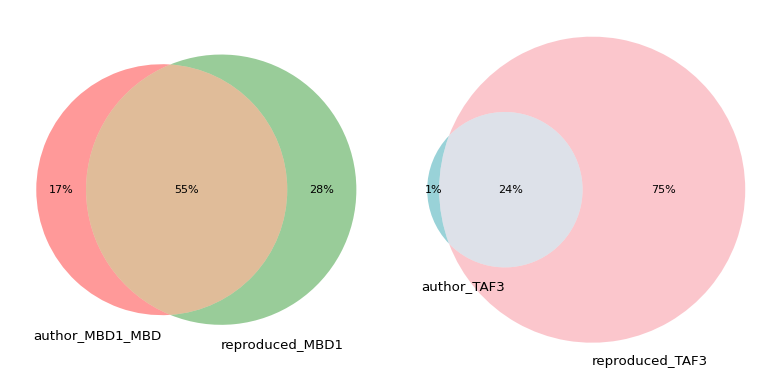